In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import KMeans
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
DIR_DATASET = "./data_set/"

In [2]:
filename = "N-CMAPSS_DS05.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (6912652, 4)
X_s shape: (6912652, 14)
X_v shape: (6912652, 14)
T shape: (6912652, 10)
A shape: (6912652, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


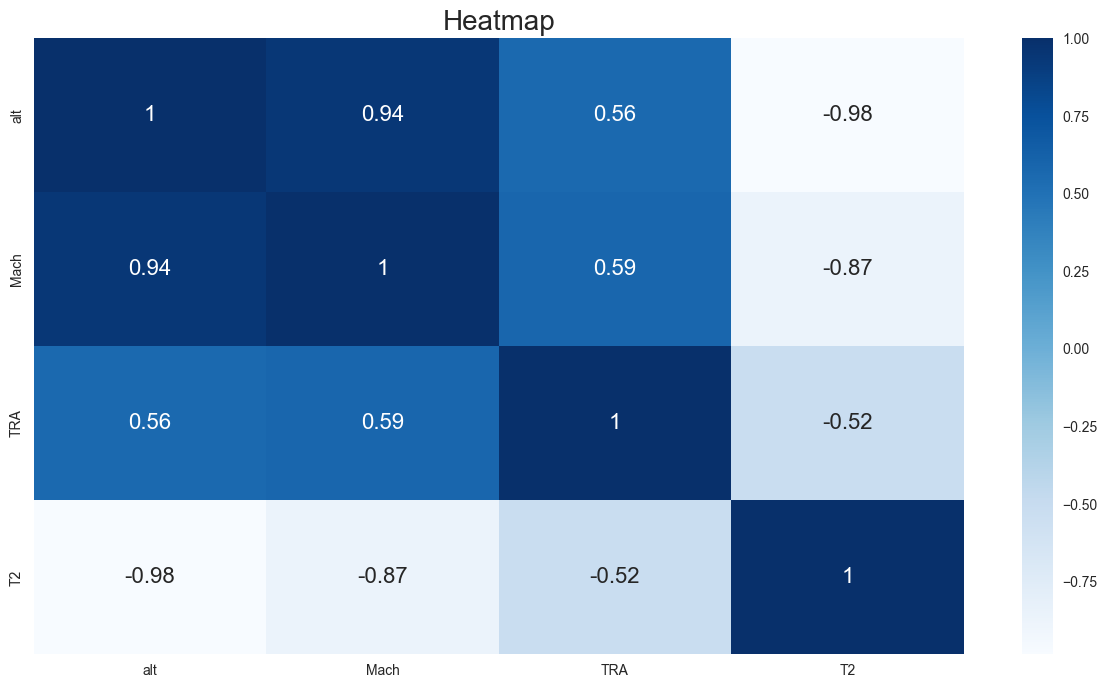

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,628.067440,1511.513103,1926.925730,1305.942703,20.030712,14.445617,20.335749,25.654299,433.588452,440.331422,16.506868,2240.817081,8822.782067,5.280657,1.0,3002.0,0.370377,81.122467,521.900827
1,628.055445,1511.458504,1926.939420,1305.955847,20.028054,14.444604,20.333050,25.650603,433.502638,440.242970,16.503124,2240.682999,8822.565341,5.279919,1.0,3010.0,0.370818,81.122467,521.904702
2,628.062671,1511.447754,1926.891685,1305.888172,20.027157,14.444141,20.332139,25.649811,433.463184,440.203438,16.499794,2240.711263,8822.534731,5.279245,1.0,3017.0,0.371259,81.122467,521.912580
3,628.074735,1511.440602,1926.851322,1305.806355,20.025641,14.443352,20.330600,25.648417,433.407051,440.146929,16.494665,2240.760181,8822.512894,5.278388,1.0,3030.0,0.372078,81.122467,521.926210
4,628.077782,1511.400057,1926.753906,1305.700646,20.023867,14.442366,20.328799,25.646643,433.331048,440.070597,16.489861,2240.761586,8822.386619,5.277163,1.0,3038.0,0.372519,81.122467,521.930527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912647,565.680901,1276.304423,1501.160669,1140.995774,15.950512,13.629508,16.193413,18.248103,224.787221,229.534568,14.234020,1595.516489,8016.541455,2.157283,10.0,3031.0,0.234738,26.718559,513.457396
6912648,565.699290,1276.354738,1501.223033,1141.053145,15.953645,13.631977,16.196594,18.251652,224.838661,229.587043,14.237732,1595.545474,8016.708826,2.157831,10.0,3024.0,0.234486,26.718559,513.471020
6912649,565.719766,1276.404304,1501.294893,1141.118499,15.957024,13.634728,16.200025,18.255466,224.890152,229.639523,14.241438,1595.568394,8016.870106,2.158413,10.0,3017.0,0.234297,26.718559,513.487702
6912650,565.743753,1276.457027,1501.368062,1141.179715,15.960714,13.637842,16.203770,18.259656,224.943430,229.693862,14.244965,1595.596953,8017.041298,2.159010,10.0,3010.0,0.234234,26.718559,513.509052


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06,6.912652e+06
mean,5.699286e+02,1.334474e+03,1.638378e+03,1.129818e+03,1.304474e+01,1.019378e+01,1.324339e+01,1.606218e+01,2.379398e+02,2.422144e+02,1.019697e+01,1.953364e+03,8.248141e+03,2.548930e+00,5.239374e+00,1.532733e+04,5.319760e-01,5.996256e+01,4.909356e+02
std,2.112542e+01,6.869315e+01,1.239105e+02,6.251462e+01,2.883393e+00,2.421477e+00,2.927303e+00,3.450926e+00,5.919650e+01,6.003612e+01,2.758136e+00,1.873247e+02,2.277543e+02,7.877672e-01,2.904136e+00,8.083096e+03,1.208898e-01,1.834395e+01,1.985279e+01
min,4.998511e+02,1.091806e+03,1.095354e+03,7.923581e+02,6.700688e+00,5.285918e+00,6.802729e+00,8.186232e+00,9.248497e+01,9.466065e+01,4.635623e+00,1.471000e+03,7.429764e+03,5.963687e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.369255e+02
25%,5.546204e+02,1.287931e+03,1.552724e+03,1.085702e+03,1.049740e+01,7.972020e+00,1.065726e+01,1.319101e+01,1.929589e+02,1.965787e+02,7.665725e+00,1.835894e+03,8.094517e+03,1.980253e+00,2.000000e+00,8.831000e+03,4.393620e-01,4.631803e+01,4.741667e+02
50%,5.678197e+02,1.329839e+03,1.647608e+03,1.120127e+03,1.338949e+01,1.060965e+01,1.359339e+01,1.617596e+01,2.256779e+02,2.301263e+02,1.051082e+01,1.997333e+03,8.237001e+03,2.340848e+00,6.000000e+00,1.346800e+04,5.371380e-01,6.257768e+01,4.960515e+02
75%,5.838195e+02,1.373982e+03,1.711727e+03,1.165307e+03,1.528072e+01,1.209400e+01,1.551342e+01,1.847904e+01,2.724938e+02,2.773639e+02,1.232305e+01,2.112084e+03,8.383625e+03,2.948869e+00,8.000000e+00,2.224600e+04,6.330240e-01,7.664008e+01,5.072438e+02
max,6.341967e+02,1.540888e+03,1.993206e+03,1.356282e+03,2.044899e+01,1.568410e+01,2.076040e+01,2.643985e+01,4.485121e+02,4.553945e+02,1.672457e+01,2.285550e+03,8.921408e+03,5.607345e+00,1.000000e+01,3.302800e+04,7.492590e-01,8.876890e+01,5.343834e+02


-1.2121797534965908e-15 1.0000000000000007
(6912652, 18)


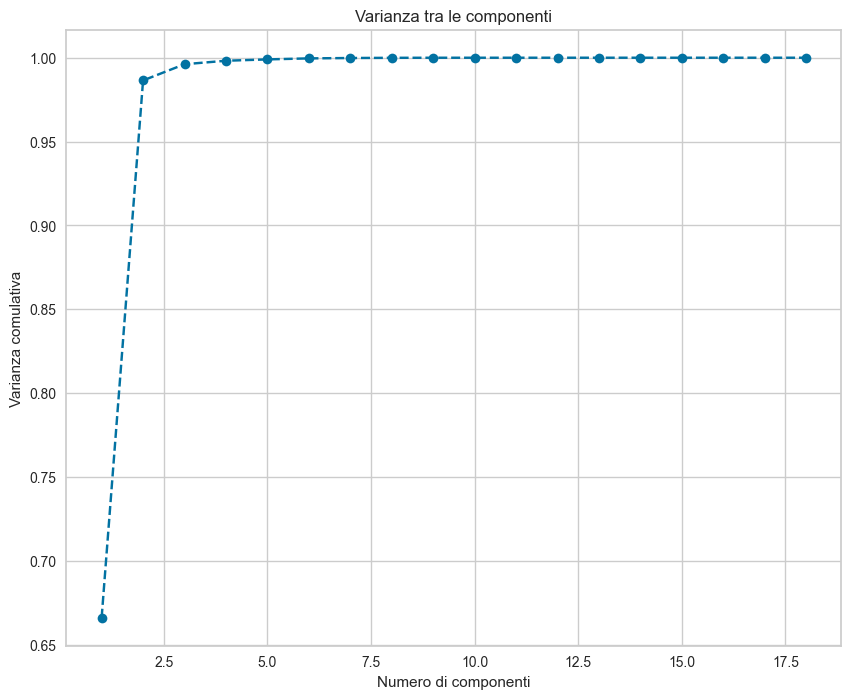

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

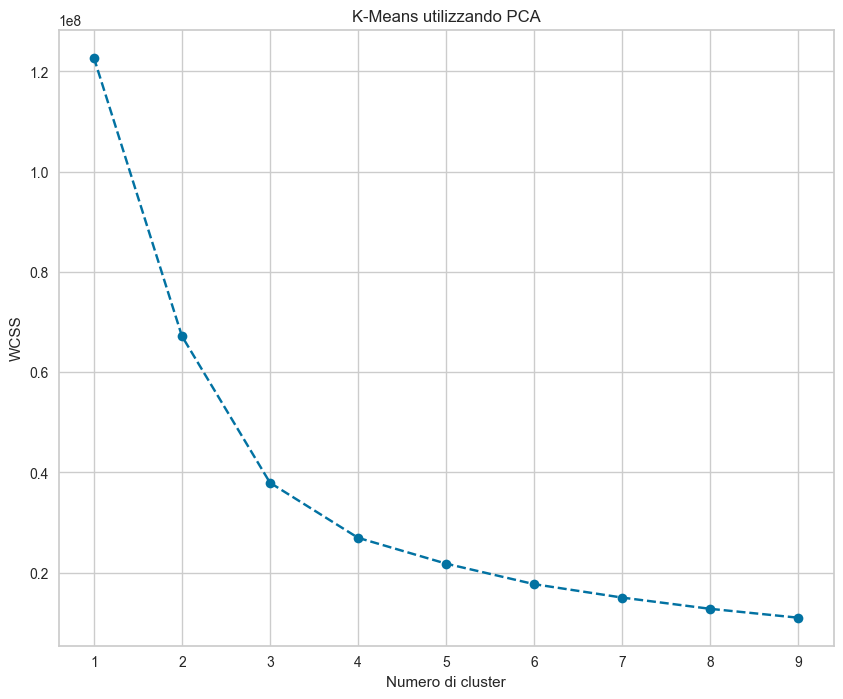

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

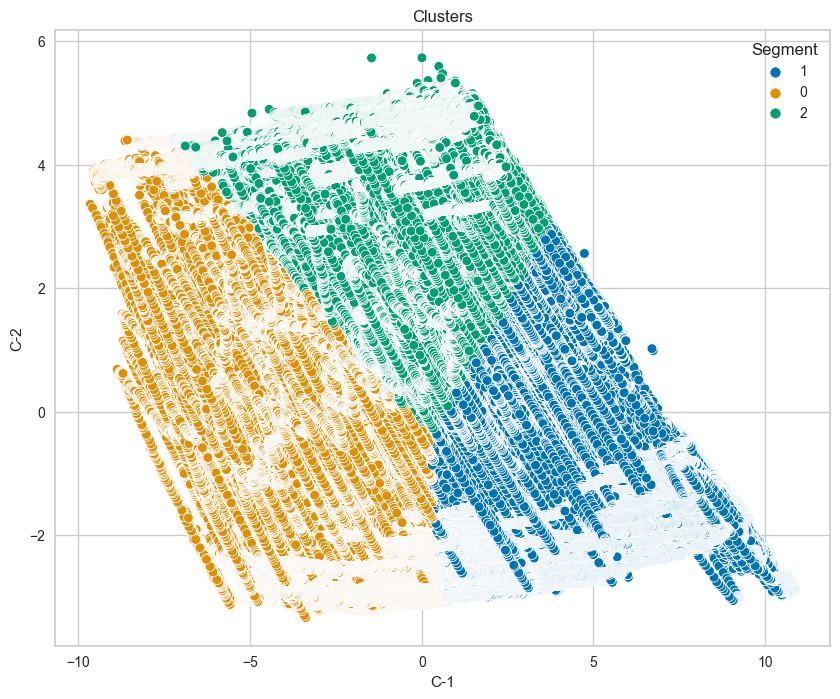

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,628.067440,1511.513103,1926.925730,1305.942703,20.030712,14.445617,20.335749,25.654299,433.588452,440.331422,...,5.280657,1.0,3002.0,0.370377,81.122467,521.900827,10.003094,-2.226864,1,1
1,628.055445,1511.458504,1926.939420,1305.955847,20.028054,14.444604,20.333050,25.650603,433.502638,440.242970,...,5.279919,1.0,3010.0,0.370818,81.122467,521.904702,9.999365,-2.227581,1,1
2,628.062671,1511.447754,1926.891685,1305.888172,20.027157,14.444141,20.332139,25.649811,433.463184,440.203438,...,5.279245,1.0,3017.0,0.371259,81.122467,521.912580,9.997042,-2.228530,1,1
3,628.074735,1511.440602,1926.851322,1305.806355,20.025641,14.443352,20.330600,25.648417,433.407051,440.146929,...,5.278388,1.0,3030.0,0.372078,81.122467,521.926210,9.993458,-2.230655,1,1
4,628.077782,1511.400057,1926.753906,1305.700646,20.023867,14.442366,20.328799,25.646643,433.331048,440.070597,...,5.277163,1.0,3038.0,0.372519,81.122467,521.930527,9.989619,-2.231178,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912647,565.680901,1276.304423,1501.160669,1140.995774,15.950512,13.629508,16.193413,18.248103,224.787221,229.534568,...,2.157283,10.0,3031.0,0.234738,26.718559,513.457396,1.512152,4.781280,2,2
6912648,565.699290,1276.354738,1501.223033,1141.053145,15.953645,13.631977,16.196594,18.251652,224.838661,229.587043,...,2.157831,10.0,3024.0,0.234486,26.718559,513.471020,1.515964,4.781994,2,2
6912649,565.719766,1276.404304,1501.294893,1141.118499,15.957024,13.634728,16.200025,18.255466,224.890152,229.639523,...,2.158413,10.0,3017.0,0.234297,26.718559,513.487702,1.519880,4.782626,2,2
6912650,565.743753,1276.457027,1501.368062,1141.179715,15.960714,13.637842,16.203770,18.259656,224.943430,229.693862,...,2.159010,10.0,3010.0,0.234234,26.718559,513.509052,1.523827,4.783042,2,2


In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [11]:
KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

5.612986680820466e-16 1.0000000000000007
(2669297, 19)
-4.595941859379106e-15 0.999999999999999
(2285389, 19)
-1.663541562168686e-15 1.0000000000000004
(1957966, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,553.963911,1314.843840,1633.527687,1091.339151,9.989725,7.551784,10.141853,12.620073,194.795203,198.125532,7.253434,2024.614001,8188.873805,2.094204,5.023995,24209.510846,0.651701,70.502712,469.134499,0.0
mean,594.019639,1407.719348,1755.072718,1199.711218,15.590382,11.790437,15.827799,19.533156,306.191547,311.390012,12.343478,2072.805149,8489.122436,3.455826,5.388537,10204.759247,0.476966,67.640536,504.652024,1.0
mean,563.573607,1275.743064,1508.781195,1100.696351,14.238308,11.931974,14.455135,16.703409,217.093782,221.577140,11.704433,1716.815734,8047.661034,2.110305,5.358892,9197.442527,0.432964,36.631226,504.646833,2.0


Text(0, 0.5, 'Flight Class # [-]')

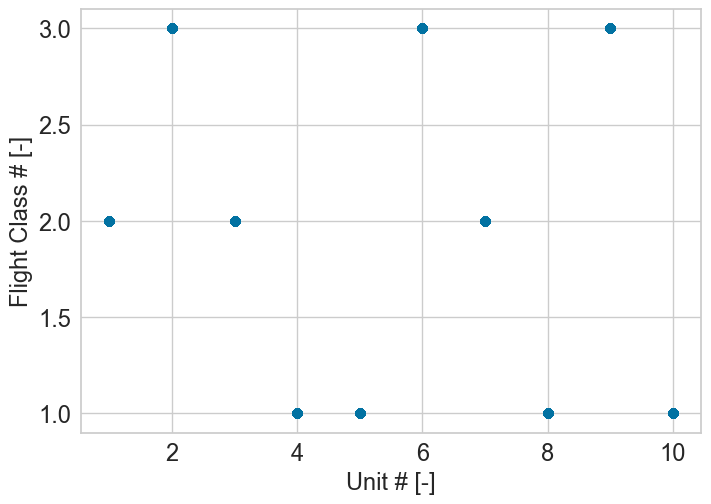

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [13]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 3, 10: 1}

In [14]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,628.067440,1511.513103,1926.925730,1305.942703,20.030712,14.445617,20.335749,25.654299,433.588452,440.331422,...,1.0,3002.0,0.370377,81.122467,521.900827,10.003094,-2.226864,1,1,2
1,628.055445,1511.458504,1926.939420,1305.955847,20.028054,14.444604,20.333050,25.650603,433.502638,440.242970,...,1.0,3010.0,0.370818,81.122467,521.904702,9.999365,-2.227581,1,1,2
2,628.062671,1511.447754,1926.891685,1305.888172,20.027157,14.444141,20.332139,25.649811,433.463184,440.203438,...,1.0,3017.0,0.371259,81.122467,521.912580,9.997042,-2.228530,1,1,2
3,628.074735,1511.440602,1926.851322,1305.806355,20.025641,14.443352,20.330600,25.648417,433.407051,440.146929,...,1.0,3030.0,0.372078,81.122467,521.926210,9.993458,-2.230655,1,1,2
4,628.077782,1511.400057,1926.753906,1305.700646,20.023867,14.442366,20.328799,25.646643,433.331048,440.070597,...,1.0,3038.0,0.372519,81.122467,521.930527,9.989619,-2.231178,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912647,565.680901,1276.304423,1501.160669,1140.995774,15.950512,13.629508,16.193413,18.248103,224.787221,229.534568,...,10.0,3031.0,0.234738,26.718559,513.457396,1.512152,4.781280,2,2,1
6912648,565.699290,1276.354738,1501.223033,1141.053145,15.953645,13.631977,16.196594,18.251652,224.838661,229.587043,...,10.0,3024.0,0.234486,26.718559,513.471020,1.515964,4.781994,2,2,1
6912649,565.719766,1276.404304,1501.294893,1141.118499,15.957024,13.634728,16.200025,18.255466,224.890152,229.639523,...,10.0,3017.0,0.234297,26.718559,513.487702,1.519880,4.782626,2,2,1
6912650,565.743753,1276.457027,1501.368062,1141.179715,15.960714,13.637842,16.203770,18.259656,224.943430,229.693862,...,10.0,3010.0,0.234234,26.718559,513.509052,1.523827,4.783042,2,2,1


In [15]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())

cluster 0
   Classe  Conteggio
0       3    1902471
1       2     760239
2       1       6587
totale cluster 0 : 2669297
cluster 1
   Classe  Conteggio
0       1     900862
1       3     707930
2       2     676597
totale cluster 1 : 2285389
cluster 2
   Classe  Conteggio
0       1     743302
1       2     611259
2       3     603405
totale cluster 2 : 1957966


In [16]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [17]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 3001.0
max: 17741.0


In [18]:
df_segm_pca_kmeans['cycle'] = df_A['cycle'].values
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    if filter_cluster['alt'].min() >= 10000:
        print('Saving Cluster',i)
        filename_out = filename.replace('.h5','')
        filename_out += "_clr_" + str(i) + ".csv"
        df_X_s_u_c_mean = filter_cluster.groupby(['unit', 'cycle']).mean()
        df_X_s_u_c_mean = pd.DataFrame(df_X_s_u_c_mean).reset_index()
        df_X_s_u_c_mean.to_csv("./dataset_csv/"+filename_out,index=False)

Saving Cluster 0
